In [1]:
#Author:Bhishma Dedhia

import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
%load_ext autoreload
%autoreload 2

In [2]:
#Training noise experiments only on finetuning
noise_array = [0.5]
for noise in noise_array:
    datapath = f'../datasets/synthetic_data_noise_{noise}/'
    config_path = '../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_noise_{noise}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)
    dscmodel.fit(interv_time,pretrain=False)

Modifying K
Fitting model on target unit


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 39.59 GiB total capacity; 434.53 MiB already allocated; 13.19 MiB free; 452.00 MiB reserved in total by PyTorch)

In [3]:
#Extracting results for Noise experiments
noise_array = [0.5,1,2]
rsc_array = []
mrsc_array = []
dsc_array = []
sync_twin = []
mc_nnm = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
id = [1,2,3,4]
for noise in noise_array:
    for i in id:
        print(noise, i)
        datapath = f'../datasets/synthetic_noise{noise}_{i}/'
        config_path = '../exp_configs/synthetic_noise/config.yaml'
        config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
        op_path = f'../logs_dir/synthetic_noise_{noise}_{i}/'
        if not(os.path.exists(op_path)):
            os.mkdir(op_path)
        random_seed = 0
        target_index = 0
        interv_time = 1500
        lowrank = False
        device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
        classes = None
        config_model = BertConfig(hidden_size = config['hidden_size'],
                                num_hidden_layers = config['n_layers'],
                                num_attention_heads = config['n_heads'],
                                intermediate_size = 4*config['hidden_size'],
                                vocab_size = 0,
                                max_position_embeddings = 0,
                                output_hidden_states = True,
                                )

        config_model.add_syn_ctrl_config(K=config['K'],
                                        pre_int_len=config['pre_int_len'],
                                        post_int_len=config['post_int_len'],
                                        feature_dim=config['feature_dim'],
                                        time_range=config['time_range'],
                                        seq_range=config['seq_range'],
                                        cont_dim=config['cont_dim'],
                                        discrete_dim=config['discrete_dim'],
                                        classes = classes)
        model = Bert2BertSynCtrl(config_model, random_seed)
        model = model.to(device)
        dscmodel = DSCModel(model,
                            config,
                            op_path,
                            target_index,
                            random_seed,
                            datapath,
                            device,
                            lowrank = False,
                            classes=None)

        model_path = f'../logs_dir/synthetic_noise_{noise}/finetune/model.pth'
        dscmodel.load_model_from_checkpoint(model_path)
        op = dscmodel.predict(interv_time)
        if noise == 1:
            np.save(op_path+'target.npy',op)
        obs = np.load(datapath+'obs1.npy')
        obs_matrix.append(obs[0])

        model_path = f'../logs_dir/synthetic_noise_{noise}/finetune_only/model.pth'
        dscmodel.load_model_from_checkpoint(model_path)
        op_2 = dscmodel.predict(interv_time)

        #MSE
        meanmatrix = np.load(datapath+'mean1.npy')
        test_mean = meanmatrix[0,interv_time:]
        pred_mean=op[interv_time:]
        pred_mean2 = op_2[interv_time:]
        print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
        print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
        mean_array_full.append(meanmatrix[0])
        mean_array.append(test_mean)
        dsc_array.append(pred_mean)
        dsc_no_pretrain.append(pred_mean2)
        rsc_array.append(np.load(datapath+'rsc_pred.npy'))
        mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))
        mc_nnm.append(pd.read_csv(datapath+'mc_nnm_pred.csv', sep=',',header=None))
        sync_twin.append(np.load(datapath+'pred_synctwin.npy'))

0.5 1
Modifying K
With pretraining: 0.4140702391038812
Without pretraining: 1.3117882124466584
0.5 2
Modifying K
With pretraining: 0.41626677962049496
Without pretraining: 1.330616147857379
0.5 3
Modifying K
With pretraining: 0.3783117796511842
Without pretraining: 1.3109220538234014
0.5 4
Modifying K
With pretraining: 0.2924703473988418
Without pretraining: 1.25546711588041
1 1
Modifying K
With pretraining: 0.5909652555901721
Without pretraining: 1.5340526776044099
1 2
Modifying K
With pretraining: 0.5613722133588968
Without pretraining: 1.4744584974502397
1 3
Modifying K
With pretraining: 0.6017875994672012
Without pretraining: 1.3933305428099683
1 4
Modifying K
With pretraining: 0.5951586897215412
Without pretraining: 1.540559451257493
2 1
Modifying K
With pretraining: 1.148147501832612
Without pretraining: 1.8259631209574054
2 2
Modifying K
With pretraining: 1.5889384694959476
Without pretraining: 2.1376289529173356
2 3
Modifying K
With pretraining: 1.02664294966848
Without pretrai

In [17]:
mc_nnm[0].values[1:,].reshape(-1)

array(['2.46511589185215', '2.89685907395576', '2.63306920372888',
       '2.64892702966895', '2.22131914896395', '2.88741029798962',
       '2.29256088605073', '1.98444311737078', '2.37933832329748',
       '2.67476616589873', '2.79073265324479', '2.71825889876078',
       '2.25354530264046', '2.30174156644626', '2.17071418040953',
       '1.76970558276506', '2.28674496869349', '2.94874487343429',
       '2.3479004648971', '2.3065216151705', '1.92191595865217',
       '2.02270460575496', '1.83326007232147', '2.25178131034374',
       '2.02951461493079', '1.96207162413787', '2.48809859802768',
       '2.07139222345104', '1.97839434972725', '2.24619851876746',
       '2.17255491643927', '2.06619663422854', '1.95189630919247',
       '2.24774215593221', '2.61663019041854', '2.1855065636552',
       '2.1045503625813', '1.86375300175906', '2.29079848045244',
       '2.2211460536843', '1.90729804801006', '2.48751419165182',
       '2.33229859039378', '2.31399586302456', '2.26370332550442',


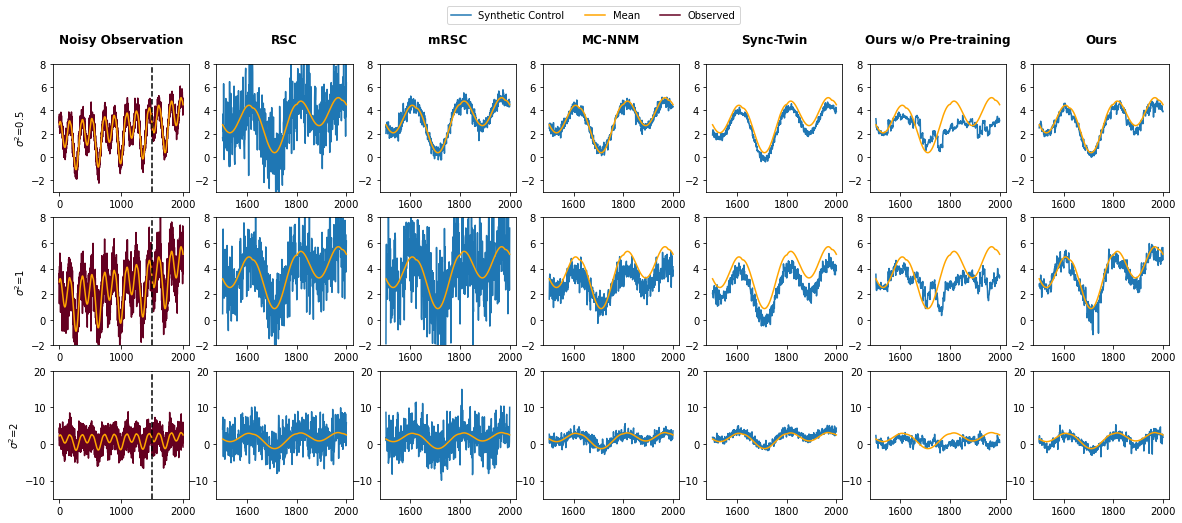

In [5]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(20, 8) , nrows=1, ncols=7, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','MC-NNM','Sync-Twin','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-2,8],[-15,20]]

for i in range(1,22,7):
    a1 = fig.add_subplot(3,7,i)
    plt.setp(a1,ylim=custom_ylim[int(i/7)])
    l1=a1.plot(x_full,obs_matrix[int(i/7)],'xkcd:maroon',label='Observed')
    l2=a1.plot(x_full,mean_array_full[int(i/7)],'orange',label='Mean')
    plt.axvline(x =1500,ymin=0, ymax =1 ,linestyle='--',color='black')
    plt.ylabel(f'$\sigma^2$={noise_array[int(i/7)]}')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+6)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l3=a.plot(x,dsc_array[int(i/7)],label='Synthetic Control')
    l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    
    a = fig.add_subplot(3,7,i+5)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l3=a.plot(x,dsc_no_pretrain[int(i/7)],label='Synthetic Control')
    l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+1)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l5=a.plot(x,rsc_array[int(i/7)],label='Synthetic Control')
    l6=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+2)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l7=a.plot(x,mrsc_array[int(i/7)],label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+3)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    df=mc_nnm[int(i/7)].to_numpy()[1:,].reshape(-1).astype('float32')
    l7=a.plot(x,df,label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+4)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l7=a.plot(x,sync_twin[int(i/7)][:,0],label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')

handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/noise.pdf',bbox_inches='tight')

plt.show()

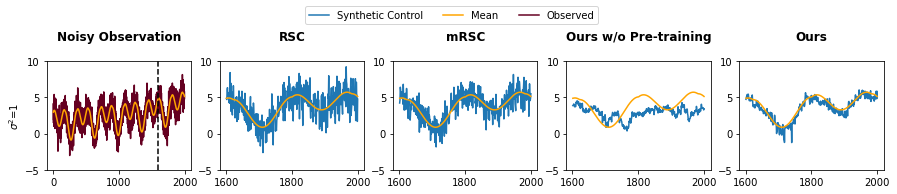

In [9]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(15,2) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-5,10],[-15,20]]

a1 = fig.add_subplot(1,5,1)
plt.setp(a1,ylim=custom_ylim[1])
l1=a1.plot(x_full,obs_matrix[1],'xkcd:maroon',label='Observed')
l2=a1.plot(x_full,mean_array_full[1],'orange',label='Mean')
plt.axvline(x =1600,ymin=0, ymax =1 ,linestyle='--',color='black')
plt.ylabel(f'$\sigma^2$={noise_array[1]}')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,5)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_array[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')

a = fig.add_subplot(1,5,4)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_no_pretrain[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,2)
plt.setp(a,ylim=custom_ylim[1])
l5=a.plot(x,rsc_array[1])
l6=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,3)
plt.setp(a,ylim=custom_ylim[1])
l7=a.plot(x,mrsc_array[1],label='Synthetic Control')
l8=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,1.1))
plt.savefig(f'./figs/noise_one.pdf',bbox_inches='tight')

plt.show()

In [5]:
#N_donor experiments on finetuning only
N_array = [6]

for N in N_array:

    datapath = f'../datasets/synthetic_data_N_{N}/'
    config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_N_{N}/'
    model_path = f'../logs_dir/synthetic_N_{N}/finetune/model.pth'
        
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)
    
    
    dscmodel.fit(interv_time,pretrain=False)
    




Modifying K
Fitting model on target unit
Iteration:0	Loss_mean:0.47808441519737244	Loss_std:0.0
Iteration:100	Loss_mean:0.1335410394333303	Loss_std:0.11944479969828967
Iteration:200	Loss_mean:0.0678761412575841	Loss_std:0.03536519881798309
Iteration:300	Loss_mean:0.041770495362579825	Loss_std:0.022595891205270766
Iteration:400	Loss_mean:0.03556770649272949	Loss_std:0.020016784585532663
Iteration:500	Loss_mean:0.030713852532207965	Loss_std:0.019233819123311523
Iteration:600	Loss_mean:0.0261569142434746	Loss_std:0.019847186684576492
Iteration:700	Loss_mean:0.023568398817442358	Loss_std:0.017233744514775513
Iteration:800	Loss_mean:0.021678978169802576	Loss_std:0.015736712347163204
Iteration:900	Loss_mean:0.02528251350624487	Loss_std:0.02183888417837275
Iteration:1000	Loss_mean:0.019754594936966897	Loss_std:0.013725144122738614
Iteration:1100	Loss_mean:0.02108183007221669	Loss_std:0.01710902635532872
Iteration:1200	Loss_mean:0.02226625819923356	Loss_std:0.018511761720091335
Iteration:1300	

Iteration:900	Loss_mean:0.019433379732072355	Loss_std:0.014489156643626135
Iteration:1000	Loss_mean:0.019304417312378065	Loss_std:0.015075710711851306
Iteration:1100	Loss_mean:0.01684107691515237	Loss_std:0.014862045811774758
Iteration:1200	Loss_mean:0.01855403566500172	Loss_std:0.01405919435436894
Iteration:1300	Loss_mean:0.017822172155138104	Loss_std:0.012945815002649241
Iteration:1400	Loss_mean:0.018011429369216785	Loss_std:0.01425906436866676
Iteration:1500	Loss_mean:0.016818023350788282	Loss_std:0.01769881727215715
Iteration:1600	Loss_mean:0.015173756282310933	Loss_std:0.017140846194781255
Iteration:1700	Loss_mean:0.015510990747716278	Loss_std:0.014445034666701728
Iteration:1800	Loss_mean:0.013462708356091752	Loss_std:0.011877861585106765
Iteration:1900	Loss_mean:0.01458780116168782	Loss_std:0.012452860794543793
Iteration:2000	Loss_mean:0.01432557518593967	Loss_std:0.011888127276864027
Iteration:2100	Loss_mean:0.016302867009362672	Loss_std:0.013652149895866323
Iteration:2200	Loss_

Iteration:1800	Loss_mean:0.0140796067006886	Loss_std:0.011701578689965903
Iteration:1900	Loss_mean:0.01799050531350076	Loss_std:0.014120318319911344
Iteration:2000	Loss_mean:0.01774345104699023	Loss_std:0.016552582466354066
Iteration:2100	Loss_mean:0.015019544947426767	Loss_std:0.012097053160043766
Iteration:2200	Loss_mean:0.01818027856061235	Loss_std:0.013261509607747959
Iteration:2300	Loss_mean:0.015920101926312782	Loss_std:0.01263266272990635
Iteration:2400	Loss_mean:0.017654311736114325	Loss_std:0.013908454442182751
Iteration:2500	Loss_mean:0.015959901101887226	Loss_std:0.013035155242879178
Iteration:2600	Loss_mean:0.015688551204511895	Loss_std:0.01347546441717042
Iteration:2700	Loss_mean:0.015815758695825934	Loss_std:0.012367282287700778
Iteration:2800	Loss_mean:0.0135373393795453	Loss_std:0.009186652968550021
Iteration:2900	Loss_mean:0.011427937811240553	Loss_std:0.008104036804715513
Iteration:3000	Loss_mean:0.015239528666716068	Loss_std:0.013746499486472353
Iteration:3100	Loss_m

Iteration:2700	Loss_mean:0.016513822764973155	Loss_std:0.013491210052993285
Iteration:2800	Loss_mean:0.015370576099958271	Loss_std:0.013705612546444987
Iteration:2900	Loss_mean:0.016952344832243397	Loss_std:0.013298371654038904
Iteration:3000	Loss_mean:0.0172495565447025	Loss_std:0.015786831105295284
Iteration:3100	Loss_mean:0.015013949864223832	Loss_std:0.01271450148549995
Iteration:3200	Loss_mean:0.01499387520365417	Loss_std:0.012002164942993361
Iteration:3300	Loss_mean:0.01722919903928414	Loss_std:0.01409500472064523
Iteration:3400	Loss_mean:0.015609335935441776	Loss_std:0.012079231365577186
Iteration:3500	Loss_mean:0.016453798122238367	Loss_std:0.014233624617439771
Iteration:3600	Loss_mean:0.015487794836517424	Loss_std:0.01217049920893722
Iteration:3700	Loss_mean:0.015305968665052206	Loss_std:0.012455213209083849
Iteration:3800	Loss_mean:0.014769680625759065	Loss_std:0.011445025474754244
Iteration:3900	Loss_mean:0.014659939515404403	Loss_std:0.01258163940404078
Iteration:4000	Loss_

In [9]:
#Extract results
N_array = [6,11,16,21]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
mc_nnm = []
synctwin = []

for N in N_array:
    for id in range(1):
        
        if N==11:
            datapath = f'../datasets/synthetic_data_noise_{id+1}/'
            config_path = '../exp_configs/synthetic_noise/config.yaml'
            config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
            op_path = '../logs_dir/synthetic/'
            if not(os.path.exists(op_path)):
                os.mkdir(op_path)
            random_seed = 0
            target_index = 0
            interv_time = 1500
            lowrank = False
            model_path = '../logs_dir/synthetic_noise_1/finetune/model.pth'
            model_path_finetune_only = '../logs_dir/synthetic_noise_1/finetune_only/model.pth'
        else:
            datapath = f'../datasets/synthetic_data_N_{N}_{id+1}/'
            config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
            config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
            op_path = f'../logs_dir/synthetic_N_{N}/'
            model_path = f'../logs_dir/synthetic_N_{N}/finetune/model.pth'
            model_path_finetune_only = f'../logs_dir/synthetic_N_{N}/finetune_only/model.pth'

        random_seed = 0
        target_index = 0
        interv_time = 1500
        lowrank = False
        
        device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
        classes = None
        config_model = BertConfig(hidden_size = config['hidden_size'],
                                num_hidden_layers = config['n_layers'],
                                num_attention_heads = config['n_heads'],
                                intermediate_size = 4*config['hidden_size'],
                                vocab_size = 0,
                                max_position_embeddings = 0,
                                output_hidden_states = True,
                                )

        config_model.add_syn_ctrl_config(K=config['K'],
                                        pre_int_len=config['pre_int_len'],
                                        post_int_len=config['post_int_len'],
                                        feature_dim=config['feature_dim'],
                                        time_range=config['time_range'],
                                        seq_range=config['seq_range'],
                                        cont_dim=config['cont_dim'],
                                        discrete_dim=config['discrete_dim'],
                                        classes = classes)
        model = Bert2BertSynCtrl(config_model, random_seed)
        model = model.to(device)
        dscmodel = DSCModel(model,
                            config,
                            op_path,
                            target_index,
                            random_seed,
                            datapath,
                            device,
                            lowrank = False,
                            classes=None)


        dscmodel.load_model_from_checkpoint(model_path)
        op = dscmodel.predict(interv_time)
        obs = np.load(datapath+'obs1.npy')
        obs_matrix.append(obs[0])


        dscmodel.load_model_from_checkpoint(model_path_finetune_only)
        op_2 = dscmodel.predict(interv_time)

        #MSE
        meanmatrix = np.load(datapath+'mean1.npy')
        test_mean = meanmatrix[0,interv_time:]
        pred_mean=op[interv_time:]
        pred_mean2 = op_2[interv_time:]
        print(N,id)
        print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
        print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
        mean_array_full.append(meanmatrix[0])
        mean_array.append(test_mean)
        dsc_array.append(pred_mean)
        dsc_no_pretrain.append(pred_mean2)
        rsc_array.append(np.load(datapath+'rsc_pred.npy'))
        mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))
        if N==11:
            mc_nnm.append(pd.read_csv('../datasets/synthetic_noise1_1/'+'mc_nnm_pred.csv', sep=',',header=None))
            synctwin.append(np.load('../datasets/synthetic_noise1_1/'+'pred_synctwin.npy'))
        else:
            mc_nnm.append(pd.read_csv(datapath+'mc_nnm_pred.csv', sep=',',header=None))
            synctwin.append(np.load(datapath+'pred_synctwin.npy'))
        


Modifying K
6 0
With pretraining: 0.5562255
Without pretraining: 1.808221
Modifying K
11 0
With pretraining: 0.5583670132851428
Without pretraining: 1.5139592474528405
Modifying K
16 0
With pretraining: 0.5719295
Without pretraining: 1.6006727
Modifying K
21 0
With pretraining: 0.5185081
Without pretraining: 2.0663536


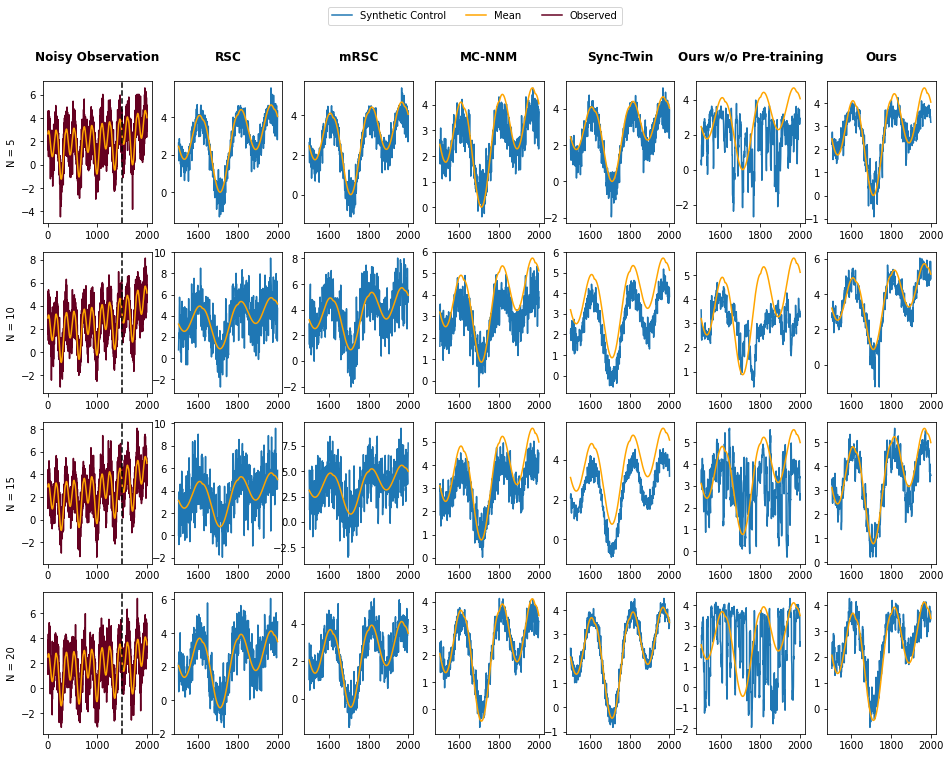

In [10]:
#Plots
fig, big_axes = plt.subplots(figsize=(16, 12) , nrows=1, ncols=7, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','MC-NNM','Sync-Twin','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

#custom_ylim = [[-3,8],[-2,8],[-15,20]]
N_array = [5,10,15,20]
for i in range(1,29,7):
        a1 = fig.add_subplot(4,7,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(x_full,obs_matrix[int(i/7)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/7)],'orange',label='Mean')
        plt.axvline(x =1500,ymin=0, ymax =1 ,linestyle='--',color='black')
        plt.ylabel(f'N = {N_array[int(i/7)]}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(4,7,i+6)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_array[int(i/7)])
        l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        a = fig.add_subplot(4,7,i+5)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/7)])
        l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(4,7,i+1)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/7)])
        l6=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(4,7,i+2)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/7)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(4,7,i+3)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mc_nnm[int(i/7)].to_numpy()[1:,].reshape(-1).astype('float32'),label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(4,7,i+4)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,synctwin[int(i/7)][:,0],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/donorpool_all.pdf',bbox_inches='tight')

plt.show()

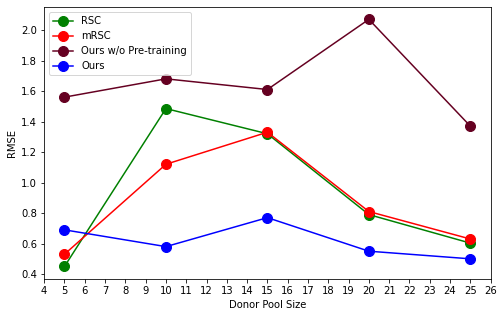

In [3]:
dsc= [0.69,0.58,0.77,0.55,0.5]
dsc_no_pretrain = [1.56,1.68,1.61,2.07,1.37]
msc = [0.53,1.12,1.33,0.81,0.63]
rsc = [0.45,1.485, 1.32 ,0.79, 0.603]
N = [5,10,15,20,25]
yint = range(3,28)
plt.figure(figsize=(8, 5))
plt.xticks(yint)

plt.plot(N,rsc,'og-',label='RSC',markersize=10)
plt.plot(N,msc,'or-',label='mRSC',markersize=10)
plt.plot(N,dsc_no_pretrain,color='xkcd:maroon',marker='o',label='Ours w/o Pre-training',markersize=10)
plt.plot(N,dsc,'ob-',label='Ours',markersize=10)
plt.xlabel('Donor Pool Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig(f'./figs/donorpool.pdf',bbox_inches='tight')

In [8]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}/'
    model_path = f'../logs_dir/synthetic_missing_{p}/finetune/model.pth'
    #model_path_finetune_only =  f'../logs_dir/synthetic_missing_{p}/finetune_only/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    interv_time = 1600
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    mask = np.load(datapath+'mask.npy')
    mask_target = mask[0,:,0]
    obs = np.load(datapath+'data.npy')[:,:,0]
    obs_matrix.append(obs[0][mask_target==0])
    print()
    x_full =  np.arange(2000)+1
    obs_x.append(x_full[mask_target==0])
    #dscmodel.load_model_from_checkpoint(model_path_finetune_only)
    #op_2 = dscmodel.predict(interv_time)
    
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    #pred_mean2 = op_2[interv_time:]
    print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
    #print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
    mean_array_full.append(meanmatrix[0])
    mean_array.append(test_mean)
    dsc_array.append(pred_mean)
    #dsc_no_pretrain.append(pred_mean2)
    rsc_array.append(np.load(datapath+'rsc_pred.npy'))
    mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))

Modifying K
Low rank conversion done

With pretraining: 1.7451126789476632
Modifying K
Low rank conversion done

With pretraining: 1.7911034219076487
Modifying K
Low rank conversion done

With pretraining: 2.0617820366005875
Modifying K
Low rank conversion done

With pretraining: 2.5373473827418604


In [7]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}_no_denoising/'
    model_path =  f'../logs_dir/synthetic_missing_{p}_no_denoising/finetune/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank =False,
                        classes=None)
    interv_time = 1500
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    print('Without denoising:',np.sqrt(np.mean((pred_mean - test_mean)**2)))


Modifying K
Without denoising: 1.1649465700585984
Modifying K
Without denoising: 1.3608462110252122
Modifying K
Without denoising: 1.4513699959713768
Modifying K
Without denoising: 3.174849269082771


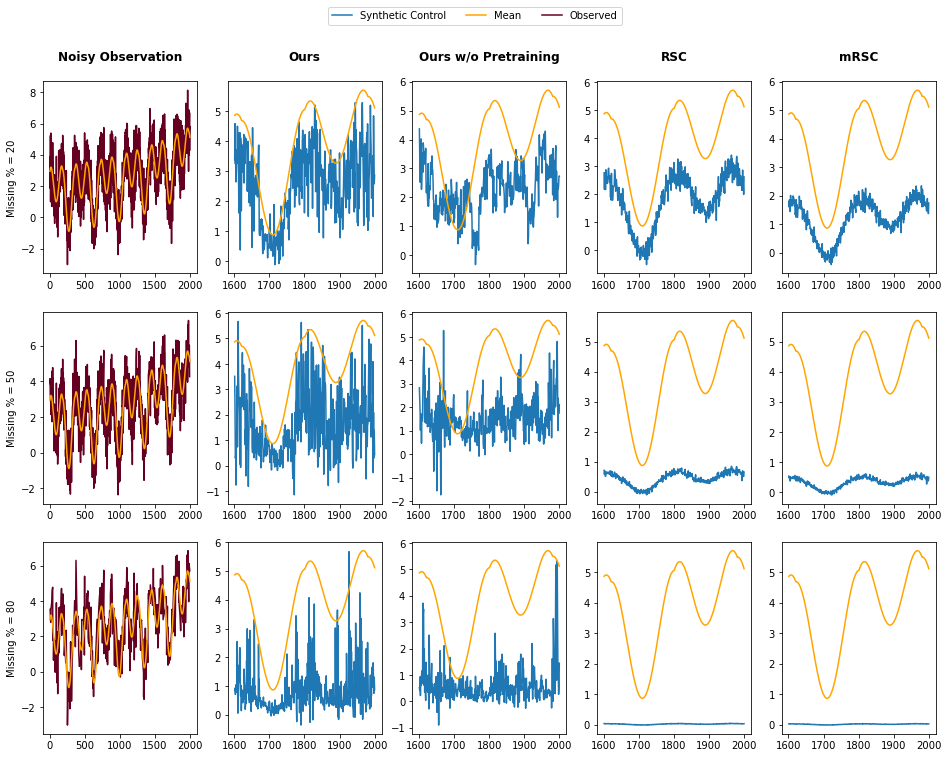

In [18]:
#Plots
fig, big_axes = plt.subplots(figsize=(16, 12) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','Ours','Ours w/o Pretraining','RSC', 'mRSC'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

p_array = [0.2,0.5,0.8]
for i in range(1,16,5):
        a1 = fig.add_subplot(3,5,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(obs_x[int(i/5)],obs_matrix[int(i/5)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/5)],'orange',label='Mean')
        plt.ylabel(f'Missing % = {int(p_array[int(i/5)]*100)}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+1)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_array[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        a = fig.add_subplot(3,5,i+2)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+3)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/5)])
        l6=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+4)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/5)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/missing.pdf',bbox_inches='tight')

plt.show()